In [2]:
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np

import sklearn
import sklearn.metrics
import matplotlib
import scipy

In [3]:
!ls ../experiments

delphes-gnn-skipconn-06ac0681  delphes-gnn-skipconn-55bb2f8a


In [13]:
def load_logs(path):
    fis = glob.glob(path)

    ds = []
    for fi in fis:
        d = json.load(open(fi, 'r'))
        l2_split = d.pop("l2_split")
        for i in range(len(l2_split)):
            d["l2_{}".format(i)] = l2_split[i]
        ds.append(d)

    df = pd.DataFrame.from_dict(ds)
    df = df.sort_values('epoch')
    return df

In [200]:
df1 = load_logs("../experiments/delphes-gnn-skipconn-06ac0681/logs_*.json")
df2 = load_logs("../experiments/delphes-gnn-skipconn-55bb2f8a/logs_*.json")

In [201]:
len(df1), len(df2)

(900, 900)

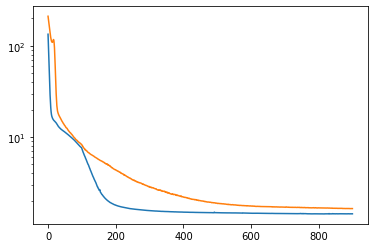

In [202]:
plt.plot(df1['l1'].values + df1['l2'].values + df1['l3'].values)
plt.plot(df2['l1'].values + df2['l2'].values + df2['l3'].values)
plt.yscale("log")

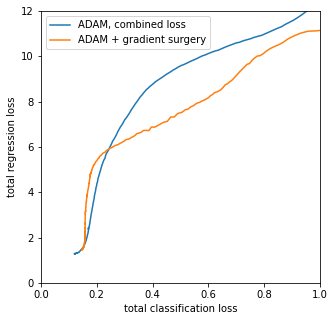

In [203]:
plt.figure(figsize=(5,5))
plt.plot(df1['l1'], df1['l2'], label="ADAM, combined loss")
plt.plot(df2['l1'], df2['l2'], label="ADAM + gradient surgery")
plt.xlabel("total classification loss")
plt.ylabel("total regression loss")
plt.xlim(0, 1)
plt.ylim(0, 12)
plt.legend()

(0.0, 0.2)

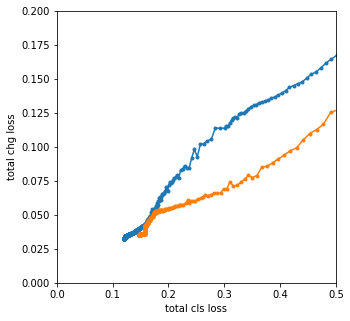

In [204]:
plt.figure(figsize=(5,5))
plt.plot(df1['l1'], df1['l3'], marker=".")
plt.plot(df2['l1'], df2['l3'], marker=".")
plt.xlabel("total cls loss")
plt.ylabel("total chg loss")
plt.xlim(0,0.5)
plt.ylim(0,0.2)

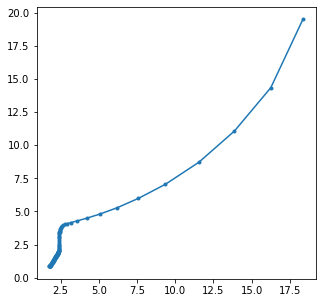

In [194]:
plt.figure(figsize=(5,5))
plt.plot(df['l2_0'], df['l2_1'], marker=".")

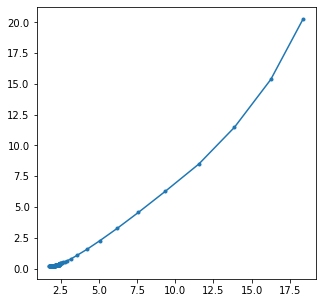

In [195]:
plt.figure(figsize=(5,5))
plt.plot(df['l2_0'], df['l2_2'], marker=".")

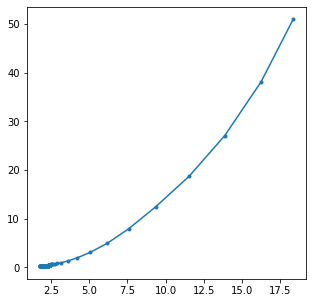

In [159]:
plt.figure(figsize=(5,5))
plt.plot(df['l2_0'], df['l2_3'], marker=".")

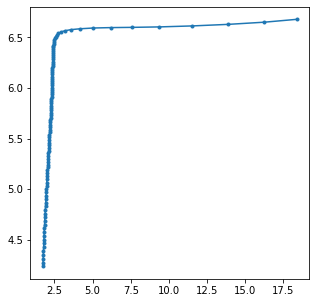

In [160]:
plt.figure(figsize=(5,5))
plt.plot(df['l2_0'], df['l2_4'], marker=".")

In [ ]:
for i in range(5):
    plt.plot(df["l2_{}".format(i)].values, label="{}".format(i))
plt.legend()
#plt.yscale("log")

In [271]:
dd = np.load("../pred_cms.npz")
X = dd["X"]
ygen = dd["ygen"]
ycand = dd["ycand"]
ypred = dd["ypred"]
ypred_raw = dd["ypred_raw"]

ypred_raw_sm = scipy.special.softmax(ypred_raw, axis=-1)

X_f = X.reshape((X.shape[0]*X.shape[1], X.shape[2]))
ygen_f = ygen.reshape((ygen.shape[0]*ygen.shape[1], ygen.shape[2]))
ycand_f = ycand.reshape((ycand.shape[0]*ycand.shape[1], ycand.shape[2]))
ypred_f = ypred.reshape((ypred.shape[0]*ypred.shape[1], ypred.shape[2]))
ypred_raw_f = ypred_raw.reshape((ypred_raw.shape[0]*ypred_raw.shape[1], ypred_raw.shape[2]))
ypred_raw_f_sm = scipy.special.softmax(ypred_raw_f, axis=-1)

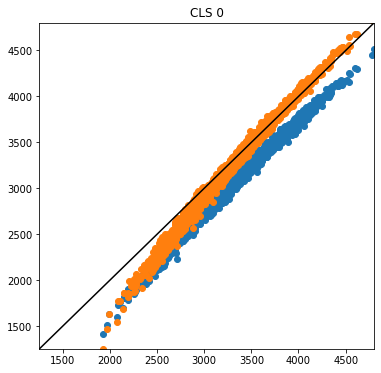

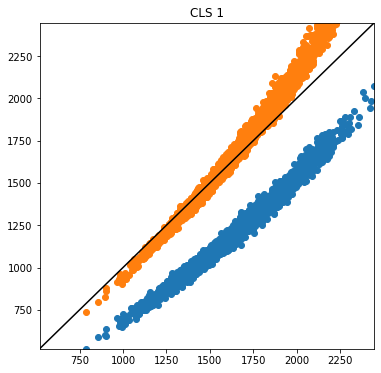

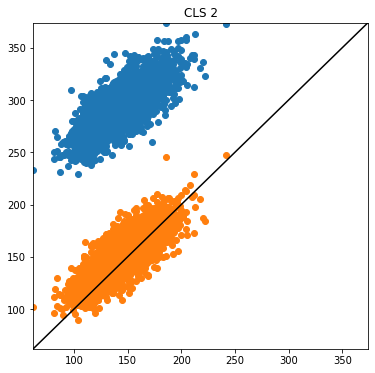

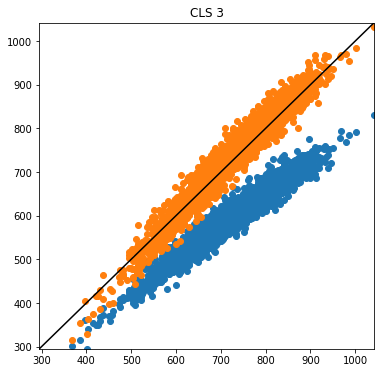

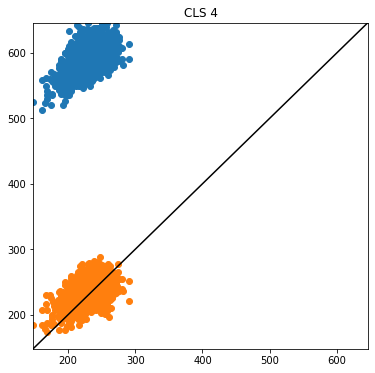

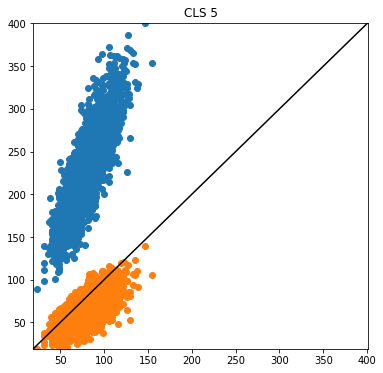

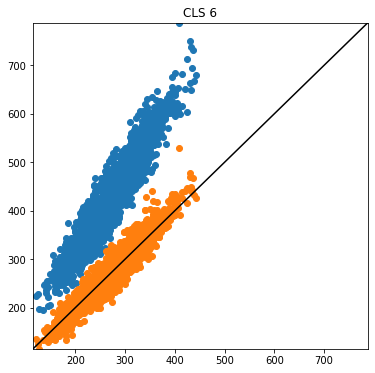

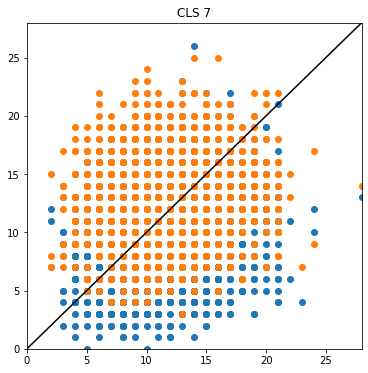

In [301]:
ypred_raw_sm2 = ypred_raw_sm.copy()

ypred_raw_sm2[:, :, 0] += 0.44
ypred_raw_sm2[:, :, 2] += -0.12
ypred_raw_sm2[:, :, 3] += 0.12
ypred_raw_sm2[:, :, 4] += -0.01
ypred_raw_sm2[:, :, 5] += 0.04
ypred_raw_sm2[:, :, 6] += 0.06
ypred_raw_sm2[:, :, 7] += 0.25

#ypred_raw_sm2[ypred_raw_sm2[:, :, 2]<0.6, 2] = 0

ypred_ids = np.argmax(ypred_raw_sm2, axis=-1)
for icls in range(8):
    npred1 = np.sum(ypred[:, :, 0] == icls, axis=1)
    npred2 = np.sum(ypred_ids == icls, axis=1)
    ngen = np.sum(ygen[:, :, 0] == icls, axis=1)

    a = min(np.min(npred1), np.min(npred2), np.min(ngen))
    b = max(np.max(npred1), np.min(npred2), np.max(ngen))

    plt.figure(figsize=(6,6))
    plt.title("CLS {}".format(icls))
    plt.scatter(ngen, npred1)
    plt.scatter(ngen, npred2)
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.plot([a, b], [a, b], color="black")

In [4]:
import sklearn
import sklearn.calibration

In [5]:
import tensorflow_probability

In [25]:
def calibration_curve(y_true, y_prob, bins):

    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    ece_val = np.sum(np.abs(prob_true - prob_pred))
    return prob_true, prob_pred, ece_val

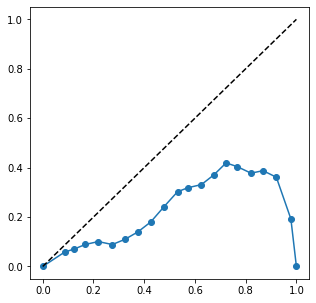

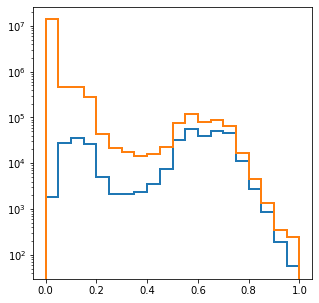

In [83]:
plt.figure(figsize=(5,5))
icls = 2
nbins = 21
p_true, p_pred, ece_val = calibration_curve(ygen_f[:, 0]==icls, ypred_raw_f_sm[:, icls], np.linspace(0,1,nbins))
plt.plot(p_pred, p_true, marker="o")
plt.plot([0,1], [0,1], color="black", ls="--")

plt.figure(figsize=(5,5))
plt.hist(ypred_raw_f_sm[ygen_f[:, 0]==icls, icls], np.linspace(0,1,nbins), histtype="step", lw=2)
plt.hist(ypred_raw_f_sm[ygen_f[:, 0]!=icls, icls], np.linspace(0,1,nbins), histtype="step", lw=2)
plt.yscale("log")

In [227]:
def total_ece(xs):
    global niter
    ece_val = 0.0
    n = ypred_raw_f.shape[-1]
    a = xs[:n]
    b = xs[n:]
    sm = scipy.special.softmax(ypred_raw_f[:200000]*a + b, axis=-1)
    for icls in range(n):
        _, _, _ece_val = calibration_curve(ygen_f[:200000, 0]==icls, sm[:, icls], np.linspace(0,1,10))
        ece_val += _ece_val
    if niter%100==0:
        print(niter, ece_val)
    niter += 1
    return ece_val

In [228]:
niter = 0
ret = scipy.optimize.minimize(
    total_ece,
    np.random.randn(16),
    method='nelder-mead',
    options={'fatol': 0.0000001}
)
ret.x

0 27.037114401524114
100 23.972559648742163
200 20.11319703093131
300 17.353832335139302
400 17.326741083742814
500 17.320799273013776
600 17.319836831213113
700 17.319307501458127
800 17.31926671086814
900 17.319270873266834
1000 17.319240215923806
1100 17.319225724429764
1200 17.319218546092
1300 17.319240926522397
1400 17.319211156181176
1500 17.319210740517327
1600 17.319210323335255


array([ 0.74555006, -0.59532527, -0.03172145, -1.36065306,  0.04405831,
       -1.14908253, -1.01550571, -0.64008002,  0.40420695,  0.43454788,
       -0.60554879, -0.12404356,  0.46177851,  0.4144523 , -1.91589086,
        0.79797755])

In [229]:
vals = ret.x

ypred_raw_f_sm2 = scipy.special.softmax(ypred_raw_f*vals[:8] + vals[8:], axis=-1)
ypred_raw_sm2 = scipy.special.softmax(ypred_raw*vals[:8] + vals[8:], axis=-1)

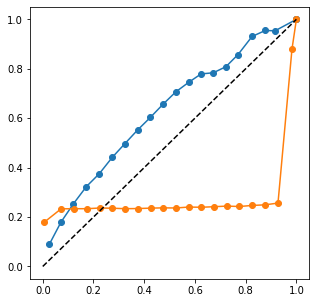

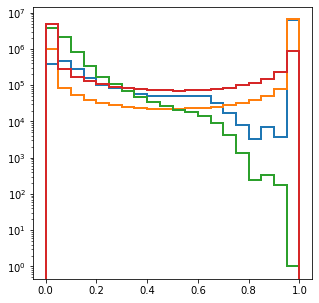

In [230]:
plt.figure(figsize=(5,5))
icls = 0
nbins = 21
p_true, p_pred, ece_val = calibration_curve(ygen_f[:, 0]==icls, ypred_raw_f_sm[:, icls], np.linspace(0,1,nbins))
p_true2, p_pred2, ece_val = calibration_curve(ygen_f[:, 0]==icls, ypred_raw_f_sm2[:, icls], np.linspace(0,1,nbins))
plt.plot(p_pred, p_true, marker="o")
plt.plot(p_pred2, p_true2, marker="o")
plt.plot([0,1], [0,1], color="black", ls="--")

plt.figure(figsize=(5,5))
plt.hist(ypred_raw_f_sm[ygen_f[:, 0]==icls, icls], np.linspace(0,1,nbins), histtype="step", lw=2)
plt.hist(ypred_raw_f_sm2[ygen_f[:, 0]==icls, icls], np.linspace(0,1,nbins), histtype="step", lw=2)
plt.hist(ypred_raw_f_sm[ygen_f[:, 0]!=icls, icls], np.linspace(0,1,nbins), histtype="step", lw=2)
plt.hist(ypred_raw_f_sm2[ygen_f[:, 0]!=icls, icls], np.linspace(0,1,nbins), histtype="step", lw=2)
plt.yscale("log")

In [141]:
ypred_ids = np.argmax(ypred_raw_sm2, axis=-1)

In [10]:
import tensorflow_probability

In [5]:
tensorflow_probability.stats.expected_calibration_error

<function tensorflow_probability.python.stats.calibration.expected_calibration_error(num_bins, logits=None, labels_true=None, labels_predicted=None, name=None)>

In [19]:
tensorflow_probability.stats.expected_calibration_error(
    10,
    logits=ypred_raw,
    labels_true=ygen[:, :, 0].astype(np.int64)
)

InvalidArgumentError: Incompatible shapes: [500,8] vs. [500,6400] [Op:Equal]

In [126]:
#       NONE = 0,
#       TRACK = 1,
#       PS1 = 2,
#       PS2 = 3,
#       ECAL = 4,
#       HCAL = 5,
#       GSF = 6,
#       BREM = 7,
#       HFEM = 8,
#       HFHAD = 9,
#       SC = 10,
#       HO = 11,
#       HGCAL = 12,

In [9]:
# [0, 211, 130, 1, 2, 22, 11, 13]

In [10]:
cm = sklearn.metrics.confusion_matrix(ycand_f[:, 0], ypred_f[:, 0], labels=range(8))

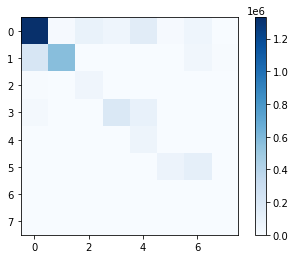

In [43]:
plt.imshow(cm, cmap="Blues", norm=matplotlib.colors.LogNorm())
plt.colorbar()

In [ ]:
pid = 4
m0 = ygen_f[:, 0] == pid
plt.hist(ypred_raw_f_sm[m0, pid], bins=np.linspace(0,1,41), histtype="step"); 
plt.hist(ypred_raw_f_sm[~m0, pid], bins=np.linspace(0,1,41), histtype="step"); 
plt.yscale("log")

In [ ]:
fpr, tpr, thresh = sklearn.metrics.roc_curve(m0, ypred_raw_f_sm[:, pid])

In [ ]:
plt.plot(thresh, fpr)
plt.plot(thresh, tpr)
plt.yscale("log")
plt.xlim(0,1)

In [ ]:
msk = (X_f[:, 0]==8) & (ygen_f[:, 0]!=0) & (ycand_f[:, 0]!=0)

In [ ]:
plt.hist(ygen_f[msk, 2], bins=np.linspace(0, 5, 41), histtype="step");
plt.hist(ycand_f[msk, 2], bins=np.linspace(0, 5, 41), histtype="step");
plt.hist(ypred_f[msk, 2], bins=np.linspace(0, 5, 41), histtype="step");

In [ ]:
c = np.unique(ygen_f[msk, 0], return_counts=True)
plt.pie(c[1], labels=c[0]);

In [ ]:
c = np.unique(ycand_f[msk, 0], return_counts=True)
plt.pie(c[1], labels=c[0]);

In [ ]:
plt.hist(ygen_f[msk, 3], bins=np.linspace(-7, 7, 41), histtype="step");
plt.hist(ycand_f[msk, 3], bins=np.linspace(-7, 7, 41), histtype="step");

In [ ]:
plt.figure(figsize=(5,5))

for pid in [1,2,3,4]:
    plt.figure(figsize=(5,5))
    plt.title("pid={}".format(pid))
    
    a = np.sum(ygen[:, :, 0]==pid, axis=1)
    b = np.sum(ycand[:, :, 0]==pid, axis=1)
    c = np.sum(ypred[:, :, 0]==pid, axis=1)
    
    minval = min([np.min(a), np.min(b), np.min(c)])
    maxval = max([np.max(a), np.max(b), np.max(c)])
    
    plt.plot([minval, maxval], [minval, maxval], ls="--", color="black")
    plt.scatter(
        b,
        c,
        marker=".", alpha=0.5
    )
    
#     plt.scatter(
#         a,
#         b,
#         marker=".", alpha=0.5
#     )

#     plt.scatter(
#         a,
#         c,
#         marker=".", alpha=0.5
#     )
    
    plt.xlim(minval, maxval)
    plt.ylim(minval, maxval)

In [ ]:
pid = 2
msk = (ygen_f[:, 0]==pid) & (ycand_f[:, 0]==pid) & (ypred_f[:, 0]==pid)

In [ ]:
b = np.linspace(0, 10, 100)
plt.hist(ygen_f[msk, 2], bins=b, histtype="step", lw=2, label="gen");
plt.hist(ycand_f[msk, 2], bins=b, histtype="step", lw=2, label="cand");
plt.hist(ypred_f[msk, 2], bins=b, histtype="step", lw=2, label="pred");
plt.legend(loc="best")

In [ ]:
b = np.linspace(-5, 5, 100)
plt.hist(ygen_f[msk, 3], bins=b, histtype="step", lw=2, label="gen");
plt.hist(ycand_f[msk, 3], bins=b, histtype="step", lw=2, label="cand");
plt.hist(ypred_f[msk, 3], bins=b, histtype="step", lw=2, label="pred");
plt.legend(loc="best")

In [ ]:
b = np.linspace(0, 50, 100)
plt.hist(ygen_f[msk, 6], bins=b, histtype="step", lw=2);
plt.hist(ycand_f[msk, 6], bins=b, histtype="step", lw=2);
plt.hist(ypred_f[msk, 6], bins=b, histtype="step", lw=2);
plt.legend(loc="best")

In [ ]:
for pid in [1,2,3,4]:
    
    msk = (ygen_f[:, 0]==pid) & (ycand_f[:, 0]==pid) & (ypred_f[:, 0]==pid)
    
    for var in [2,3,4,5,6]:
        a = ygen_f[msk, var]
        b = ycand_f[msk, var]
        c = ypred_f[msk, var]

        plt.figure(figsize=(4,4))
        plt.title("pid={} var={}".format(pid, var))
        r1 = (b-a)/a
        r2 = (c-a)/a
        
        msk1 = np.abs(r1)<10
        mean1 = np.mean(r1[msk1])
        std1 = np.std(r1[msk1])
    
        msk2 = np.abs(r2)<10
        mean2 = np.mean(r2[msk2])
        std2 = np.std(r2[msk2])
        
        plt.hist(r1, bins=np.linspace(-2, 2, 100),
            histtype="step", label="PF m={:.2f} s={:.2f}".format(mean1, std1));
        plt.hist((c-a)/a, bins=np.linspace(-2, 2, 100),
            histtype="step", label="MLPF m={:.2f} s={:.2f}".format(mean2, std2));

        plt.legend(loc="best")